# Your First AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 


**NOTES:**
- This project was created using a Docker container, with Python 3.8.10, based on image `tensorflow/tensorflow:2.12.0-gpu-jupyter`
- build and run the Docker container: `docker compose -f "docker-compose.yaml" up -d --build`

**Author**: Stefan Grandl (July 2023)



In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) from Oxford of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load the image dataset and create a pipeline.
* Build and Train an image classifier on this dataset.
* Use your trained model to perform inference on flower images.

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

## Import Resources

In [1]:
# import Tensorflow
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

2023-07-14 15:58:21.844268: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# TODO: Make all other necessary imports.
import json
import numpy as np
import matplotlib.pyplot as plt
import plotly.subplots as sp
import plotly.graph_objects as go

## Load the Dataset

Here you'll use `tensorflow_datasets` to load the [Oxford Flowers 102 dataset](https://www.tensorflow.org/datasets/catalog/oxford_flowers102). This dataset has 3 splits: `'train'`, `'test'`, and `'validation'`.  You'll also need to make sure the training data is normalized and resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet, but you'll still need to normalize and resize the images to the appropriate size.

In [3]:
# TODO: Load the dataset with TensorFlow Datasets.
dataset, dataset_info = tfds.load(
    "oxford_flowers102", as_supervised=True, with_info=True
)

# TODO: Create a training set, a validation set and a test set.
training_set, validation_set, test_set = (
    dataset["train"],
    dataset["validation"],
    dataset["test"],
)

2023-07-14 15:58:29.267143: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 29124 MB memory:  -> device: 0, name: Tesla V100-DGXS-32GB, pci bus id: 0000:07:00.0, compute capability: 7.0
2023-07-14 15:58:29.268608: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 30922 MB memory:  -> device: 1, name: Tesla V100-DGXS-32GB, pci bus id: 0000:08:00.0, compute capability: 7.0
2023-07-14 15:58:29.269106: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 30922 MB memory:  -> device: 2, name: Tesla V100-DGXS-32GB, pci bus id: 0000:0e:00.0, compute capability: 7.0


## Explore the Dataset

In [4]:
# TODO: Get the number of examples in each set from the dataset info.
print(
    "Number of examples in the train set:",
    dataset_info.splits["train"].num_examples,
)
print(
    "Number of examples in the validation set:",
    dataset_info.splits["validation"].num_examples,
)
print("Number of examples in the test set:", dataset_info.splits["test"].num_examples)

# TODO: Get the number of classes in the dataset from the dataset info.
num_classes = dataset_info.features["label"].num_classes

print("Number of classes in the dataset:", num_classes)

Number of examples in the train set: 1020
Number of examples in the validation set: 1020
Number of examples in the test set: 6149
Number of classes in the dataset: 102


2023-07-14 15:58:29.989186: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [1]
	 [[{{node Placeholder/_3}}]]
2023-07-14 15:58:29.989665: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1]
	 [[{{node Placeholder/_1}}]]


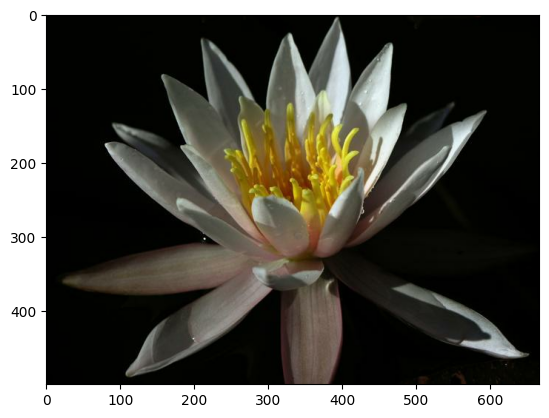

Image shape: (500, 667, 3)
Image label: 72


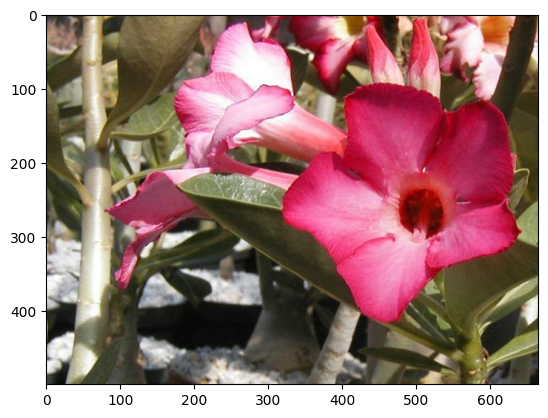

Image shape: (500, 666, 3)
Image label: 84


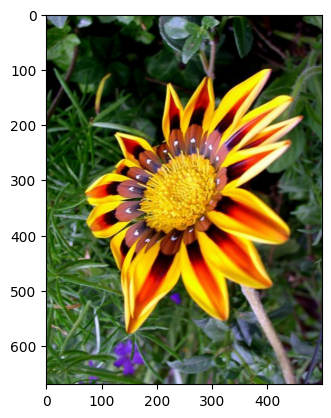

Image shape: (670, 500, 3)
Image label: 70


In [5]:
# TODO: Print the shape and corresponding label of 3 images in the training set.
for _img, _label in training_set.take(3):
    img = _img.numpy()
    label = _label.numpy()

    plt.imshow(img)
    plt.show()

    print('Image shape:', img.shape)
    print('Image label:', label)

2023-07-14 15:58:31.119792: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [1]
	 [[{{node Placeholder/_4}}]]
2023-07-14 15:58:31.120385: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [1]
	 [[{{node Placeholder/_4}}]]


Text(0.5, 1.0, '72')

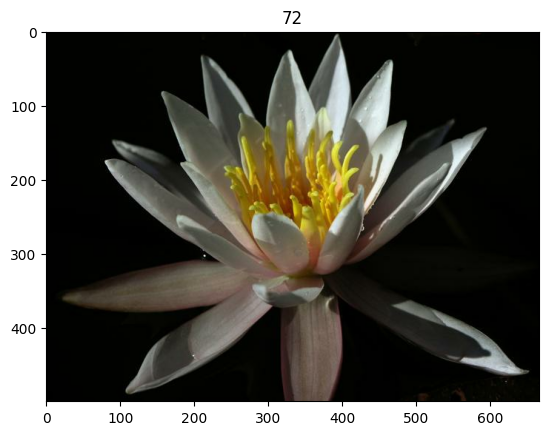

In [6]:
# TODO: Plot 1 image from the training set. Set the title 
# of the plot to the corresponding image label. 
for _img, _label in training_set.take(1):
    img = _img.numpy()
    label = _label.numpy()

plt.imshow(img)
plt.title(label)


### Label Mapping

You'll also need to load in a mapping from label to category name. You can find this in the file `label_map.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/3.7/library/json.html). This will give you a dictionary mapping the integer coded labels to the actual names of the flowers.

In [147]:
with open('app/label_map.json', 'r') as f:
    class_names = json.load(f)

2023-07-14 15:58:31.668820: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [1]
	 [[{{node Placeholder/_3}}]]
2023-07-14 15:58:31.669396: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [1]
	 [[{{node Placeholder/_4}}]]


Text(0.5, 1.0, 'azalea')

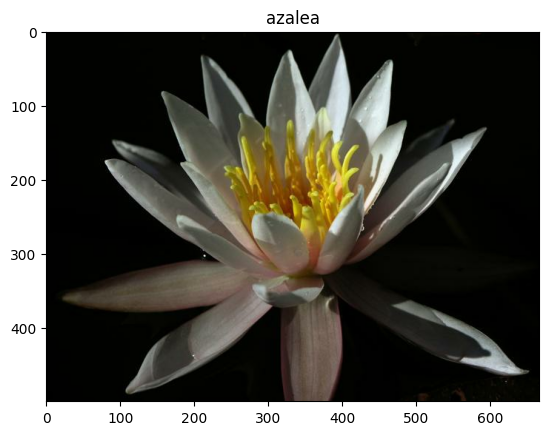

In [8]:
# TODO: Plot 1 image from the training set. Set the title 
# of the plot to the corresponding class name. 
for _img, _label in training_set.take(1):
    img = _img.numpy()
    label = _label.numpy()

plt.imshow(img)
plt.title(class_names[str(label)])


## Create Pipeline

In [9]:
# TODO: Create a pipeline for each set.

BATCH_SIZE = 32
IMG_SIZE = 224
TRAIN_SPLIT = 60

n_imgs_total = dataset_info.splits['train'].num_examples
n_imgs_train = (n_imgs_total * TRAIN_SPLIT) // 100

def prepare_img(_img, _label):
    img = tf.cast(_img, tf.float32)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img /= 255
    return img, _label


batches_train = training_set.shuffle(n_imgs_train).map(prepare_img).batch(BATCH_SIZE).prefetch(1)
batches_val   = validation_set.map(prepare_img).batch(BATCH_SIZE).prefetch(1)
batches_test  = test_set.map(prepare_img).batch(BATCH_SIZE).prefetch(1)

# Build and Train the Classifier

Now that the data is ready, it's time to build and train the classifier. You should use the MobileNet pre-trained model from TensorFlow Hub to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! 

Refer to the rubric for guidance on successfully completing this section. Things you'll need to do:

* Load the MobileNet pre-trained network from TensorFlow Hub.
* Define a new, untrained feed-forward network as a classifier.
* Train the classifier.
* Plot the loss and accuracy values achieved during training for the training and validation set.
* Save your trained model as a Keras model. 

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right.

**Note for Workspace users:** One important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module. Also, If your model is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

In [169]:
# TODO: Build and train your network.

# load MobileNet from TensorFlow Hub
module_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
mobilenet = hub.KerasLayer(module_url, input_shape=(IMG_SIZE, IMG_SIZE, 3), trainable=False)

# create a new model using MobileNet as a feature extractor
model = tf.keras.Sequential([
    mobilenet,
    tf.keras.layers.Dense(num_classes, activation='softmax') # add a final classification layer
])

model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_4 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense_4 (Dense)             (None, 102)               130662    
                                                                 
Total params: 2,388,646
Trainable params: 130,662
Non-trainable params: 2,257,984
_________________________________________________________________


In [170]:
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

Num GPUs: 3


In [171]:
# train the model
EPOCHS = 50
N_CONSEC_EPOCHS = 5

model.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy'],
    )

# stop training the validation loss if it doesn't get improved for N_CONSEC_EPOCHS consecutive epochs
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss', 
    patience = N_CONSEC_EPOCHS,
    min_delta = 0.05,
    )

history = model.fit(
    batches_train,
    epochs = EPOCHS,
    validation_data = batches_val,
    callbacks = [early_stopping],
    )

Epoch 1/50


2023-07-14 20:44:11.349779: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/zeros_like/StatefulPartitionedCall' with dtype float and shape [?,1,1,1280]
	 [[{{node gradients/zeros_like/StatefulPartitionedCall}}]]
2023-07-14 20:44:11.349915: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall' with dtype float and shape [?,7,7,1280]
	 [[{{node gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall}}]]
2023-07-14 20:44:11.350017: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

32/32 [==============================] - 6s 63ms/step - loss: 4.2570 - accuracy: 0.1108 - val_loss: 3.0630 - val_accuracy: 0.3745
Epoch 2/50
32/32 [==============================] - 2s 40ms/step - loss: 2.0620 - accuracy: 0.6588 - val_loss: 2.0016 - val_accuracy: 0.6422
Epoch 3/50
32/32 [==============================] - 2s 40ms/step - loss: 1.1055 - accuracy: 0.8892 - val_loss: 1.5292 - val_accuracy: 0.7363
Epoch 4/50
32/32 [==============================] - 1s 39ms/step - loss: 0.6714 - accuracy: 0.9578 - val_loss: 1.2960 - val_accuracy: 0.7667
Epoch 5/50
32/32 [==============================] - 2s 42ms/step - loss: 0.4469 - accuracy: 0.9804 - val_loss: 1.1504 - val_accuracy: 0.7902
Epoch 6/50
32/32 [==============================] - 2s 38ms/step - loss: 0.3205 - accuracy: 0.9902 - val_loss: 1.0661 - val_accuracy: 0.8000
Epoch 7/50
32/32 [==============================] - 2s 40ms/step - loss: 0.2399 - accuracy: 0.9971 - val_loss: 0.9961 - val_accuracy: 0.8059
Epoch 8/50
32/32 [======

In [172]:
# TODO: Plot the loss and accuracy values achieved during training for the training and validation set.

training_accuracy   = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
training_loss       = history.history['loss']
validation_loss     = history.history['val_loss']

epochs_range = range(len(training_accuracy))

fig = sp.make_subplots(rows=2, cols=1, subplot_titles=("Accuracy", "Loss"))

fig.add_trace(go.Scatter(x=list(epochs_range), y=training_accuracy, mode='lines', name='Training Accuracy'), row=1, col=1)
fig.add_trace(go.Scatter(x=list(epochs_range), y=validation_accuracy, mode='lines', name='Validation Accuracy'), row=1, col=1)

fig.add_trace(go.Scatter(x=list(epochs_range), y=training_loss, mode='lines', name='Training Loss'), row=2, col=1)
fig.add_trace(go.Scatter(x=list(epochs_range), y=validation_loss, mode='lines', name='Validation Loss'), row=2, col=1)

fig.update_layout(
    title=f"Training and Validation Metrics (early stopping after epoch {len(training_accuracy)})",
    xaxis_title='Epochs',
    height=600,
    showlegend=True,
)

fig.update_yaxes(title_text="Accuracy", row=1, col=1)
fig.update_yaxes(title_text="Loss", row=2, col=1)

fig.show()

## Testing your Network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [173]:
# TODO: Print the loss and accuracy values achieved on the entire test set.

# First calculate test accuracy and loss...
test_loss, test_accuracy = model.evaluate(batches_test)


193/193 [==============================] - 3s 17ms/step - loss: 0.8984 - accuracy: 0.7835


In [174]:
# then print the final values
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")


Test Accuracy: 0.7835
Test Loss: 0.8984


## Save the Model

Now that your network is trained, save the model so you can load it later for making inference. In the cell below save your model as a Keras model (*i.e.* save it as an HDF5 file).

In [175]:
# TODO: Save your trained model as a Keras model.

tf_model_filepath = 'app/model/tf_model.h5'
model.save(tf_model_filepath)


## Load the Keras Model

Load the Keras model you saved above.

In [176]:
# TODO: Load the Keras model

reloaded_keras_model = tf.keras.models.load_model(
    tf_model_filepath, 
    custom_objects={
        'KerasLayer': hub.KerasLayer
        }
    )

reloaded_keras_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_4 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense_4 (Dense)             (None, 102)               130662    
                                                                 
Total params: 2,388,646
Trainable params: 130,662
Non-trainable params: 2,257,984
_________________________________________________________________


# Inference for Classification

Now you'll write a function that uses your trained network for inference. Write a function called `predict` that takes an image, a model, and then returns the top $K$ most likely class labels along with the probabilities. The function call should look like: 

```python
probs, classes = predict(image_path, model, top_k)
```

If `top_k=5` the output of the `predict` function should be something like this:

```python
probs, classes = predict(image_path, model, 5)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

Your `predict` function should use `PIL` to load the image from the given `image_path`. You can use the [Image.open](https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.open) function to load the images. The `Image.open()` function returns an `Image` object. You can convert this `Image` object to a NumPy array by using the `np.asarray()` function.

The `predict` function will also need to handle pre-processing the input image such that it can be used by your model. We recommend you write a separate function called `process_image` that performs the pre-processing. You can then call the `process_image` function from the `predict` function. 

### Image Pre-processing

The `process_image` function should take in an image (in the form of a NumPy array) and return an image in the form of a NumPy array with shape `(224, 224, 3)`.

First, you should convert your image into a TensorFlow Tensor and then resize it to the appropriate size using `tf.image.resize`.

Second, the pixel values of the input images are typically encoded as integers in the range 0-255, but the model expects the pixel values to be floats in the range 0-1. Therefore, you'll also need to normalize the pixel values. 

Finally, convert your image back to a NumPy array using the `.numpy()` method.

In [177]:
# TODO: Create the process_image function

def process_image(_img: np.ndarray) -> np.ndarray:
    
    # Convert the image into a TensorFlow Tensor
    img_tensor = tf.convert_to_tensor(_img)
    
    # Resize it to the appropriate size using tf.image.resize
    img = tf.image.resize(img_tensor, (IMG_SIZE, IMG_SIZE))
    
    # In order to normalize the images we are going to divide the pixel values by 255. 
    img /= 255
    
    return img.numpy()

To check your `process_image` function we have provided 4 images in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

The code below loads one of the above images using `PIL` and plots the original image alongside the image produced by your `process_image` function. If your `process_image` function works, the plotted image should be the correct size. 

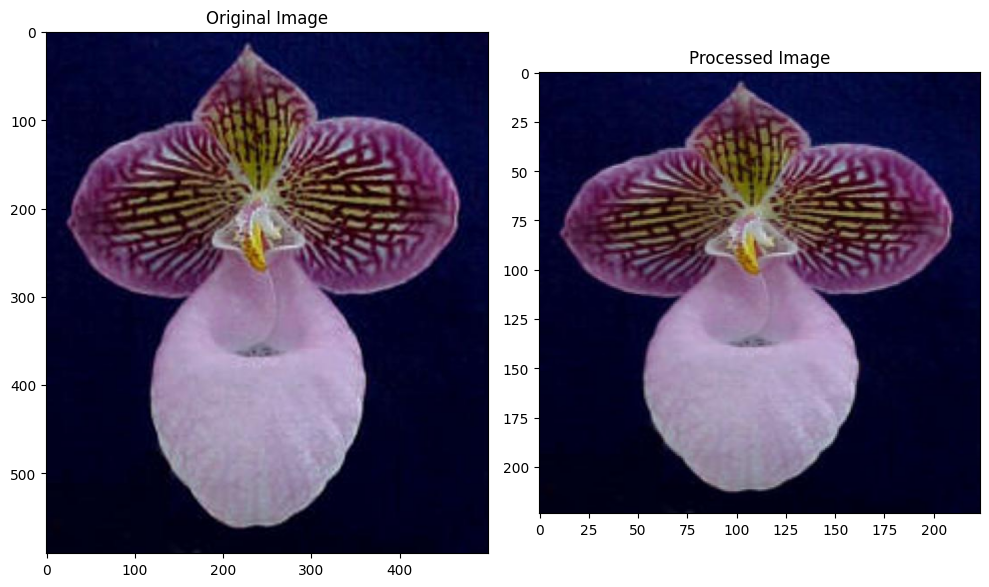

In [178]:
from PIL import Image

image_path = 'app/test_images/hard-leaved_pocket_orchid.jpg'
im = Image.open(image_path)
test_image = np.asarray(im)

processed_test_image = process_image(test_image)

fig, (ax1, ax2) = plt.subplots(figsize=(10,10), ncols=2)
ax1.imshow(test_image)
ax1.set_title('Original Image')
ax2.imshow(processed_test_image)
ax2.set_title('Processed Image')
plt.tight_layout()
plt.show()

Once you can get images in the correct format, it's time to write the `predict` function for making inference with your model.

### Inference

Remember, the `predict` function should take an image, a model, and then returns the top $K$ most likely class labels along with the probabilities. The function call should look like: 

```python
probs, classes = predict(image_path, model, top_k)
```

If `top_k=5` the output of the `predict` function should be something like this:

```python
probs, classes = predict(image_path, model, 5)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

Your `predict` function should use `PIL` to load the image from the given `image_path`. You can use the [Image.open](https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.open) function to load the images. The `Image.open()` function returns an `Image` object. You can convert this `Image` object to a NumPy array by using the `np.asarray()` function.

**Note:** The image returned by the `process_image` function is a NumPy array with shape `(224, 224, 3)` but the model expects the input images to be of shape `(1, 224, 224, 3)`. This extra dimension represents the batch size. We suggest you use the `np.expand_dims()` function to add the extra dimension. 

In [179]:
# TODO: Create the predict function
from typing import Tuple, List

def predict(img_path: str, model: tf.keras.Model, top_k: int) -> Tuple[np.ndarray, List[str]]:

    # Set top_k to 1 if it's less than 1, otherwise use the provided value
    top_k = 1 if top_k < 1 else top_k
    
    # open and convert the image to a NumPy array
    img = Image.open(img_path)
    img_arr = np.asarray(img)
    
    # preprocess the image
    processed_img = process_image(img_arr)
    processed_img_batch = np.expand_dims(processed_img, axis=0)
    
    # make predictions
    prediction = model.predict(processed_img_batch)

    # get the top k probabilities and corresponding classes
    probs, classes = tf.math.top_k(prediction, top_k)
    probs = probs.numpy().squeeze()
    classes = classes.numpy().squeeze()

    # convert the classes to strings
    classes = [str(value) for value in classes]
    
    return probs, classes

test_image_path: str = 'app/test_images/hard-leaved_pocket_orchid.jpg'
top_k: int = 5
probs, classes = predict(test_image_path, reloaded_keras_model, top_k)

# print the results
print([round(_prob,4) for _prob in probs])
print(classes)

1/1 [==============================] - 1s 539ms/step
[0.9986, 0.0003, 0.0002, 0.0002, 1e-04]
['1', '67', '5', '76', '79']


# Sanity Check

It's always good to check the predictions made by your model to make sure they are correct. To check your predictions we have provided 4 images in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

In the cell below use `matplotlib` to plot the input image alongside the probabilities for the top 5 classes predicted by your model. Plot the probabilities as a bar graph. The plot should look like this:

<img src='assets/inference_example.png' width=600px>

You can convert from the class integer labels to actual flower names using `class_names`. 

1/1 [==============================] - 0s 33ms/step
Predicted classes:
- orange dahlia
- english marigold
- blanket flower
- osteospermum
- bishop of llandaff
1/1 [==============================] - 0s 40ms/step
Predicted classes:
- wild pansy
- silverbush
- balloon flower
- windflower
- mexican aster
1/1 [==============================] - 0s 37ms/step


Predicted classes:
- hard-leaved pocket orchid
- bearded iris
- tiger lily
- passion flower
- anthurium
1/1 [==============================] - 0s 36ms/step
Predicted classes:
- cautleya spicata
- wallflower
- red ginger
- siam tulip
- snapdragon


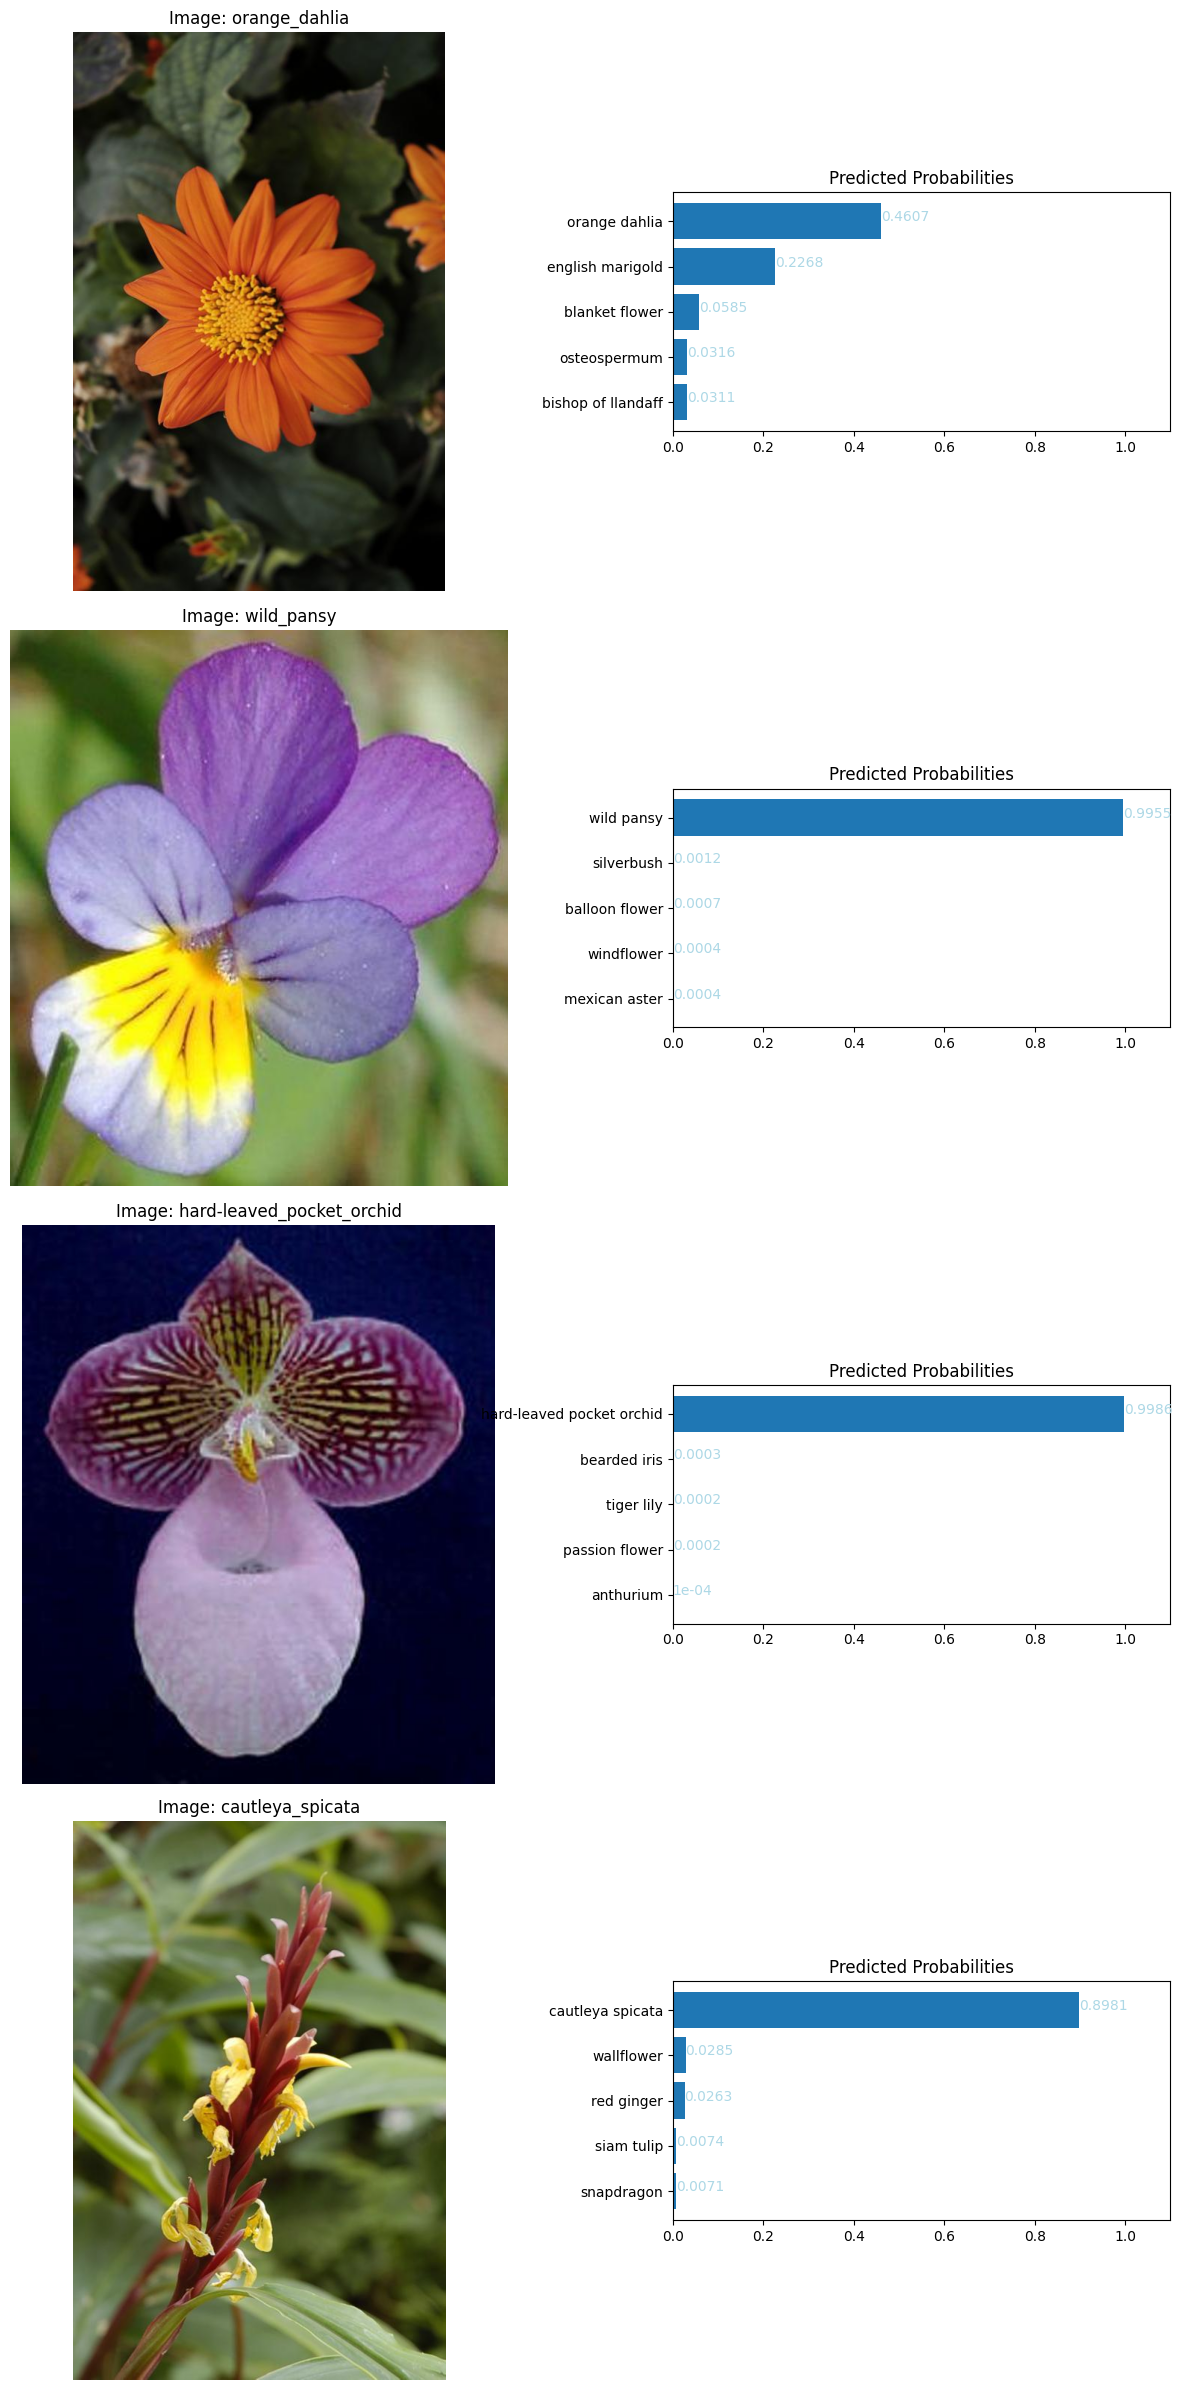

In [180]:
# TODO: Plot the input image along with the top 5 classes

from pathlib import Path

# Define the test image paths and corresponding labels
test_images_dir = Path('app/test_images')
test_image_paths = [str(file) for file in test_images_dir.glob('*.jpg')]
test_labels = [file.stem for file in test_images_dir.glob('*.jpg')]

# Create subplots for each test image
fig, axes = plt.subplots(nrows=len(test_image_paths), ncols=2, figsize=(12, 6 * len(test_image_paths)))

for i, (img_path, label) in enumerate(zip(test_image_paths, test_labels)):
    
    # Predict probabilities and classes for the current image
    probs, classes = predict(img_path, reloaded_keras_model, top_k)

    flower_classes = []
    print("Predicted classes:")
    for idx in classes:
        print("-", class_names[str(int(idx)+1)])
        flower_classes.append(class_names[str(int(idx)+1)])

    # Load and display the image
    img = Image.open(img_path)
    axes[i, 0].imshow(img)
    axes[i, 0].set_title(f"Image: {label}")
    axes[i, 0].axis('off')

    # Plot the probabilities as a bar graph
    y_pos = np.arange(len(classes))
    axes[i, 1].barh(y_pos, probs, align='center')
    axes[i, 1].set_title("Predicted Probabilities")
    axes[i, 1].set_aspect(0.1)
    axes[i, 1].set_xlim(0, 1.1)
    axes[i, 1].set_yticks(y_pos, classes)
    axes[i, 1].set_yticklabels(flower_classes)

    for j, v in enumerate(probs):
        axes[i, 1].text(v, j, str(round(v,4)), color='lightblue')

    axes[i, 1].invert_yaxis()

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()